In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data=pd.read_excel('ts_data.xlsx')
data.head()

,Time,Value
0,1,0.000000
1,2,-0.090263
2,3,0.749995
3,4,1.247887
4,5,0.131282


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    10000 non-null  int64  
 1   Value   10000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 156.4 KB


In [4]:
data.shape

(10000, 2)

### 1) Before applying Auto Regression model, we first have to make time series STATIONARY.
#### WE CAN DO THIS BY:
* VISUAL INSPECTION
* STATISTICAL TESTS -----> AUGUMENTED DICKEY FULLER TEST (adfuller test)

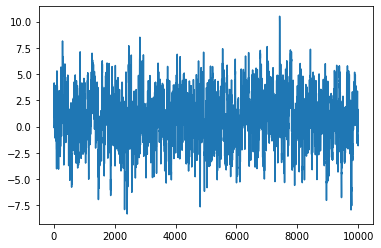

In [5]:
y=data['Value']
x=data['Time']
plt.plot(x,y)

##### IMPORTING ADFULLER TEST:


In [8]:
from statsmodels.tsa.stattools import adfuller

In [12]:
X = data["Value"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -22.184930
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


WE REJECT THE NULL HYPETHESIS AND ACCEPT THE ALTERNATE HYPOTHESIS.
TIME SERIES IS STATIONARY

### 2) AFTER FINDING THE SERIES IS STATIONARY OR NOT:
##### FIND THE CORRECT NUMBER OF LAGS IN TIME SERIES ON WHICH CURRENT VALUE IS DEPENDENT FOR MODELLING AR MODEL:
* FOR THIS WE HAVE TO PLOT PACF (PARTIAL AUTO COMPRESSION FUNCTION)

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\ps109\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


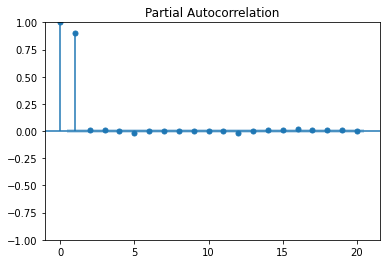

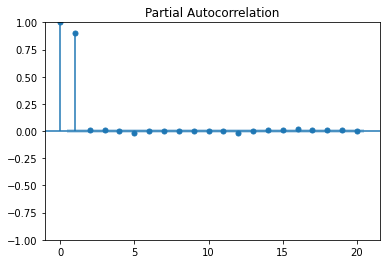

In [14]:
plot_pacf(X,lags=20)

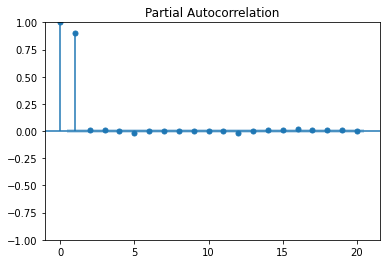

In [16]:
plot_pacf(X,lags=20);
# we have to provide colon after this line

##### ON Y-AXIS THERE IS 'PEARSON CORRELATION COEFFICIENT' AND ON X-AXIS THERE IS 'TIME LAG'

* FROM THIS IT IS CLEAR THAT CURRENT VALUE DEPENDS ON THE PREVIOUS VALUE ONLY i.e AR MODEL should be of 1st order.

In [20]:
df=data.copy()
dx=data.copy()

In [19]:
df['new']=df['Value'].shift(1)
df.head()
#shift by 1 value

,Time,Value,new
0,1,0.000000,NaN
1,2,-0.090263,0.000000
2,3,0.749995,-0.090263
3,4,1.247887,0.749995
4,5,0.131282,1.247887


In [22]:
dx['new']=dx['Value'].shift(2)
dx.head()
# shift by 2 value

,Time,Value,new
0,1,0.000000,NaN
1,2,-0.090263,NaN
2,3,0.749995,0.000000
3,4,1.247887,-0.090263
4,5,0.131282,0.749995


In [18]:
data['new']=data['Value'].shift()
data.head()
#default shift of 1

,Time,Value,new
0,1,0.000000,NaN
1,2,-0.090263,0.000000
2,3,0.749995,-0.090263
3,4,1.247887,0.749995
4,5,0.131282,1.247887


NOW WE CAN DROP 'TIME' COLUMN AND NaN ROW AS WELL

In [23]:
data.drop('Time',axis=1,inplace=True)
data.dropna(axis=0,inplace=True)
data.head()

,Value,new
1,-0.090263,0.000000
2,0.749995,-0.090263
3,1.247887,0.749995
4,0.131282,1.247887
5,0.562619,0.131282


### 3) TRAIN-TEST SPLIT

In [24]:
x=data.Value.values
y=data.new.values

In [28]:
train_size=int(len(x)*0.8)

In [30]:
x_train,x_test=x[:train_size],x[train_size:]
y_train,y_test=y[:train_size],y[train_size:]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7999,)
(2000,)
(7999,)
(2000,)


In [31]:
x_train=x_train.reshape(-1,1)
x_test=x_test.reshape(-1,1)

### 4) MODELLING

In [32]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

In [33]:
lr.fit(x_train,y_train)

LinearRegression()

In [34]:
lr.coef_

array([0.90548742])

In [35]:
lr.intercept_

0.06822494315175809

Y(t)=b+a*Y(t-1)

a=0.90548742, b=0.06822494315175809

WE HAVE FOUND THESE

In [37]:
y_pred=lr.predict(x_test)

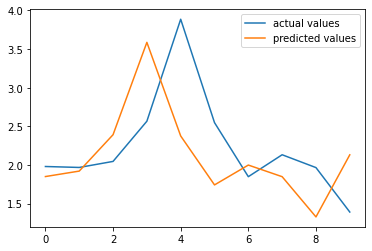

In [40]:
plt.plot(y_test[:10],label='actual values')
plt.plot(y_pred[:10],label='predicted values')
plt.legend()

### USING ARIMA (AR MODELLING)

In [44]:
import statsmodels.api as sm

In [47]:
model = sm.tsa.arima.ARIMA(y_train, order=(1,0,0))
result = model.fit()

In [48]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7999
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -11364.740
Date:                Thu, 18 Aug 2022   AIC                          22735.480
Time:                        11:57:34   BIC                          22756.441
Sample:                             0   HQIC                         22742.655
                               - 7999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7242      0.119      6.111      0.000       0.492       0.957
ar.L1          0.9055      0.005    189.838      0.000       0.896       0.915
sigma2         1.0034      0.016     62.499      0.0